In [1]:
import tensorflow.keras as keras
from tensorflow.keras import backend as K
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline

In [2]:
# First a few tools for this -particular- example...
from keras.applications.xception import Xception
from keras.preprocessing import image
from keras.applications.xception import preprocess_input, decode_predictions

In [3]:
def grab_image(img_path):
    img = image.load_img(img_path, target_size=(200,200))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x
X = np.concatenate(
 [grab_image('./dog_images/dog_%d.jpg'%(i))
 for i in range(1500)])
X.shape

(1500, 200, 200, 3)

In [4]:
# 37 cats in there (label 1, and all else 0)
Y = np.loadtxt('./dog_types.csv')
# Take a look at the first 10...
Y[0:10]

array([1., 1., 3., 2., 3., 6., 4., 0., 1., 1.])

In [5]:
# Note the input size (there is only one channel - intensity)
# for these images...
# Input Images (28, 28, 1)
x = keras.layers.Input(X.shape[1:])
y = x
y = keras.layers.Conv2D(64, kernel_size=(4,4), activation='relu')(y)
y = keras.layers.Conv2D(64, kernel_size=(4,4), activation='relu')(y)
y = keras.layers.MaxPool2D(pool_size=(4,4))(y)
#y = keras.layers.Dropout(0.25)(y)
y = keras.layers.Flatten()(y)
y = keras.layers.Dense(128, activation='relu')(y)
y = keras.layers.Dense(128, activation='relu')(y)
y = keras.layers.Dense(128, activation='relu')(y)
#y = keras.layers.Dropout(0.25)(y)
# Output Logits (10)
y = keras.layers.Dense(len(np.unique(Y)))(y)
model = keras.Model(x,y)
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
 optimizer=keras.optimizers.Adam(lr=0.01),
 metrics=[keras.metrics.SparseCategoricalAccuracy()])

2022-04-28 01:04:19.865196: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-28 01:04:19.865258: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-28 01:04:19.865309: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-cgg3a): /proc/driver/nvidia/version does not exist
2022-04-28 01:04:19.865689: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The 

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 197, 197, 64)      3136      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 194, 194, 64)      65600     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 147456)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               18874496  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512 

In [7]:
data_generator = keras.preprocessing.image.ImageDataGenerator(
 width_shift_range=0.05,
 height_shift_range=0.05,
 horizontal_flip=True)
split_point = 1200 # 80%/20% (48000,12000)
dg_trainer = data_generator.flow(X,
 Y,
 batch_size=20)

In [8]:
# Note that we provide dg_trainer instead
# of x_train, y_train, AND
# we slice the validation_data and provide
# the inputs/targets as a tuple.
epochs = 30
history = model.fit(dg_trainer,
 epochs=epochs,
 verbose=1)

2022-04-28 01:04:21.298975: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
75/75 [==============================] - 302s 4s/step - loss: 13.7097 - sparse_categorical_accuracy: 0.1633
Epoch 2/30
75/75 [==============================] - 299s 4s/step - loss: 1.9248 - sparse_categorical_accuracy: 0.1600
Epoch 3/30
75/75 [==============================] - 299s 4s/step - loss: 1.9225 - sparse_categorical_accuracy: 0.1767
Epoch 4/30
75/75 [==============================] - 296s 4s/step - loss: 1.9228 - sparse_categorical_accuracy: 0.1807
Epoch 5/30
75/75 [==============================] - 299s 4s/step - loss: 1.9237 - sparse_categorical_accuracy: 0.1673
Epoch 6/30
75/75 [==============================] - 299s 4s/step - loss: 1.9222 - sparse_categorical_accuracy: 0.1720
Epoch 7/30
75/75 [==============================] - 299s 4s/step - loss: 1.9209 - sparse_categorical_accuracy: 0.1700
Epoch 8/30
75/75 [==============================] - 299s 4s/step - loss: 1.9211 - sparse_categorical_accuracy: 0.1713
Epoch 9/30
75/75 [==============================] - 301

In [9]:
# Final Result - Generalization!
score = model.evaluate(X, Y, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

47/47 [==============================] - 25s 508ms/step - loss: 1.9184 - sparse_categorical_accuracy: 0.1820
Test loss: 1.9183613061904907
Test accuracy: 0.18199999630451202


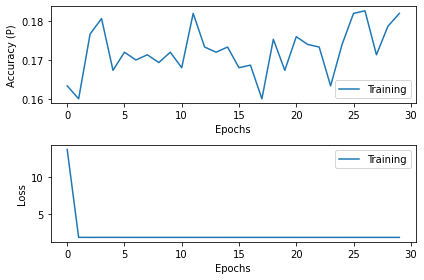

In [10]:
plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['sparse_categorical_accuracy'])
#plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.ylabel('Accuracy (P)')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='lower right')
# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()